## WeRateDogs - Wrangling, Analyzing and Visualizing

### Table of Contents

- <a href='Introduction'></a> [Introduction](#Introduction)
-  <a href='Gathering'></a> [Gathering](#Gathering)
-  <a href='Visual_Assesment'></a>[Visual_Assesment](#Visual_Assesment)
- <a href='Identified_issues'></a>[Identified issues](#Identified_issues)
-  <a href='Tidy_the_Data'></a>[Tidy the data](#Tidy_the_Data)
-  <a href='Cleaning_Quality_issues'></a>[Cleaning Quality Issues](#Cleaning_Quality_issues)
-  <a href='Exploratory_Data_Analysis'></a> [Exploratory Data Analysis](#Exploratory_Data_Analysis)
-  <a href='Asking Questions'></a> [Asking Questions](#Asking_Questions)
- <a href='Visualizations'></a> [Visualizations](#Visualizations) 

#### <a id='Introduction'></a>[Introduction](#Introduction)

In this document I'll gather, assess and clean the tweet archive of Twitter user @dog_rates. WeRateDogs™ is a community page on twitter designated to rating dogs on their appearences and stories, and which was formed by the user @dog_rates in 2015. The page has since grown extremely in popularity, with many users sharing its content and requesting their dogs being rated aswell. The site is a driving force for the development of the 'dog culture', with it's famous terms like "pupper", "mlem", "floof" etc. They also developed their own unusual rating system over time, in which almost every dog is rated above 10/10, because "they're good dogs".

In [92]:
#import Packages
import pandas as pd
import numpy as np
import requests
import io
import json
import tweepy as tp
import json
import calendar
import seaborn as sns
sns.set(font_scale=1.25)
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
% matplotlib inline
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

#### <a id='Gathering'></a> [Gathering](#Gathering)

First we read the twitter archive collected as CSV.

In [2]:
# Creating a dataFrame  twittwer_archive from twitter-archive-enhanced.csv
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
#Check the sample of the data
twitter_archive.sample(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
809,771500966810099713,NaN,NaN,2016-09-02 00:12:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Dakota. He's just saying hi. That's al...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/771500966...,12,10,Dakota,None,None,None,None
1227,713909862279876608,NaN,NaN,2016-03-27 02:05:49 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Doug. His nose is legendary af. 12/10 ...,NaN,NaN,NaN,https://vine.co/v/iDWlapaXWmm,12,10,Doug,None,None,None,None


Download the image prediction from the link provided.

In [4]:
# Store the content of the .tsv file to r using the request library
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv').content

In [5]:
#creatin a dataframe using the read_csv function
image_predictions = pd.read_csv(io.StringIO(r.decode('utf-8')), sep=None,engine='python')

In [6]:
#Visual assesment
image_predictions.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
202,669683899023405056,https://pbs.twimg.com/media/CUsx8q_WUAA-m4k.jpg,1,Pomeranian,0.998275,True,Chihuahua,0.000605,True,Pekinese,0.000516,True
1455,777621514455814149,https://pbs.twimg.com/media/Csqqoo5WEAAMTVW.jpg,1,chow,0.999823,True,Norwich_terrier,0.000056,True,Pomeranian,0.000028,True
789,690597161306841088,https://pbs.twimg.com/media/CZV-c9NVIAEWtiU.jpg,1,Lhasa,0.097500,True,koala,0.091934,False,sunglasses,0.091505,False
1570,794926597468000259,https://pbs.twimg.com/media/CwglhZVXgAAc3_w.jpg,1,teddy,0.569566,False,bath_towel,0.173745,False,toy_poodle,0.037662,True
1191,739932936087216128,https://pbs.twimg.com/media/CkTFEe-W0AA90m1.jpg,1,redbone,0.243904,True,beagle,0.210975,True,vizsla,0.076443,True


In [8]:
#Twitter API credentials
consumer_key = "consumer key"
consumer_secret = "consumer_secret"
access_token = "-access_token"
access_secret = "access_secret"

In [9]:
#connect to the twitter API using the Tweepy's OAuthHandler
auth = tp.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tp.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

In [ ]:
# retreives a list of dictionaries from the twitter api, with informations about each tweets id, favorite count, and retweet count
df_list = []
errors = []
for id in twitter_archive['tweet_id']:
    try:
        tweet = api.get_status(id, tweet_mode='extended')
        df_list.append({'tweet_id': str(tweet.id),
                        'favorite_count': int(tweet.favorite_count),
                        'retweet_count': int(tweet.retweet_count)})
    except Exception as e:
        print(str(id) + " : " + str(e))
        errors.append(id)

In [ ]:
# check the number of total unretreivable id's
len(errors)

In [ ]:
# saving the list of dictionaries in a json formatted txt file
with open('tweet_json.txt', 'w') as outfile:  
    json.dump(df_list, outfile)

In [8]:
# loading the json file into a dataframe tweetjson_df
with open('tweet_json.txt', 'r') as file:
    tweetjson_df = pd.DataFrame(json.load(file), columns=['tweet_id', 'favorite_count', 'retweet_count'])

In [9]:
#Visual assesment
tweetjson_df.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,37768,8230
1,892177421306343426,32448,6081
2,891815181378084864,24435,4023
3,891689557279858688,41108,8377
4,891327558926688256,39309,9085


#### <a id='Visual_Assesment'></a>[Visual_Assesment](#'Visual_Assesment')

In [10]:
#checking a smple of the twitter archive data frame b
twitter_archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
612,796904159865868288,NaN,NaN,2016-11-11 02:35:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Tyrone. He's a leaf wiz...,6.873173e+17,4.196984e+09,2016-01-13 16:56:30 +0000,https://twitter.com/dog_rates/status/687317306...,11,10,Tyrone,None,None,None,None
1212,715342466308784130,NaN,NaN,2016-03-31 00:58:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Oscar. He's a world renowned snowball ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/715342466...,10,10,Oscar,None,None,None,None
2149,669684865554620416,6.693544e+17,4.196984e+09,2015-11-26 01:11:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After countless hours of research and hundreds...,NaN,NaN,NaN,NaN,11,10,None,None,None,None,None
848,766069199026450432,NaN,NaN,2016-08-18 00:28:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Juno. She can see your future. 12/10 h...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/766069199...,12,10,Juno,None,None,None,None
163,860276583193509888,NaN,NaN,2017-05-04 23:34:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jordy. He likes to go on adventures an...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/860276583...,12,10,Jordy,None,None,None,None
1272,709225125749587968,NaN,NaN,2016-03-14 03:50:21 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Walker. He's a Butternut Khalifa. Appe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/709225125...,11,10,Walker,None,None,None,None
294,837482249356513284,NaN,NaN,2017-03-03 01:58:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Waffles. He's a ship captain in real l...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/837482249...,13,10,Waffles,None,None,None,None
1052,742528092657332225,NaN,NaN,2016-06-14 01:24:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Maxaroni. He's pumped as hell for the ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/742528092...,10,10,Maxaroni,None,None,None,None
1888,674781762103414784,NaN,NaN,2015-12-10 02:44:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Bedazzled pup here. Fashionable af. Super yell...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674781762...,8,10,None,None,None,None,None
159,860981674716409858,NaN,NaN,2017-05-06 22:16:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Lorenzo. He's an avid nift...,8.605638e+17,4.196984e+09,2017-05-05 18:36:06 +0000,https://www.gofundme.com/help-lorenzo-beat-can...,13,10,Lorenzo,None,None,None,None


##### Observations:
- retweeted_status_id,retweeted_status_user_id are probably identified as float
- doggo, floofer, pupper and puppo should be one column

In [11]:
#Checking the datatypes, nulls and columns using info  
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

##### Observations:
- tweet_id is int but retweeted_status_id,retweeted_status_user_id is float. All should be one datatype probably string(object) would be better.
- Expanded urls have missing values
- There are approximately 15% of retweets 
- We saw a lot of None in the above sample but name doesnt show any null
- There is a significant number of replies also

In [12]:
#checking the rating Demonominators
twitter_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [14]:
twitter_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

##### Observation:
- inconsistency in denominators

In [15]:
# checks for duplicated entries
twitter_archive[twitter_archive.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [16]:
#checking the Name for unique values
twitter_archive['name'].value_counts()[0:10]

None       745
a           55
Charlie     12
Lucy        11
Cooper      11
Oliver      11
Lola        10
Tucker      10
Penny       10
Winston      9
Name: name, dtype: int64

##### Observation:
- Majority is None it should be replaced with Nan instead

In [17]:
#unique values for the denominator
twitter_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [18]:
twitter_archive['rating_numerator'].value_counts()[:10]

12    558
11    464
10    461
13    351
9     158
8     102
7      55
14     54
5      37
6      32
Name: rating_numerator, dtype: int64

##### Observation: 
- There are some very high numerators. How can that happen? Is the data not extracted using the correct regexp?

In [21]:
# Getting a sample of Image-predictions
image_predictions.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1271,749996283729883136,https://pbs.twimg.com/media/CmfoyrrW8AA8v7w.jpg,1,Old_English_sheepdog,0.515319,True,West_Highland_white_terrier,0.151040,True,soft-coated_wheaten_terrier,0.056420,True
1495,783347506784731136,https://pbs.twimg.com/media/CVuQ2LeUsAAIe3s.jpg,1,Cardigan,0.611525,True,Pembroke,0.368566,True,Chihuahua,0.003330,True
2025,881906580714921986,https://pbs.twimg.com/media/DD0pWm9XcAAeSBL.jpg,1,Weimaraner,0.291539,True,Chesapeake_Bay_retriever,0.278966,True,koala,0.127017,False
1076,717421804990701568,https://pbs.twimg.com/media/CfTLUYWXEAEkyES.jpg,2,miniature_pinscher,0.286479,True,Italian_greyhound,0.084134,True,beagle,0.064697,True
1074,717009362452090881,https://pbs.twimg.com/media/CfNUNetW8AAekHx.jpg,1,Siberian_husky,0.506154,True,Eskimo_dog,0.269656,True,malamute,0.060658,True
1946,862457590147678208,https://pbs.twimg.com/media/C_gQmaTUMAAPYSS.jpg,1,home_theater,0.496348,False,studio_couch,0.167256,False,barber_chair,0.052625,False
563,678021115718029313,https://pbs.twimg.com/media/CWjQm5gXAAA9GkD.jpg,1,miniature_pinscher,0.822048,True,Doberman,0.096085,True,Rottweiler,0.032709,True
19,666273097616637952,https://pbs.twimg.com/media/CT8T1mtUwAA3aqm.jpg,1,Italian_greyhound,0.176053,True,toy_terrier,0.111884,True,basenji,0.111152,True
1779,828409743546925057,https://pbs.twimg.com/media/C38aQYgXAAMY2Wh.jpg,1,teddy,0.908457,False,toy_poodle,0.018040,True,standard_poodle,0.012667,True
388,673355879178194945,https://pbs.twimg.com/media/CVg9mTYWIAAu7J6.jpg,1,Rottweiler,0.529248,True,miniature_pinscher,0.168296,True,Appenzeller,0.100452,True


In [22]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [23]:
image_predictions['p1'].value_counts()[:10]

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
chow                   44
Samoyed                43
toy_poodle             39
Pomeranian             38
cocker_spaniel         30
Name: p1, dtype: int64

In [24]:
image_predictions['p2'].value_counts()[:10]

Labrador_retriever          104
golden_retriever             92
Cardigan                     73
Chihuahua                    44
Pomeranian                   42
Chesapeake_Bay_retriever     41
French_bulldog               41
toy_poodle                   37
cocker_spaniel               34
Siberian_husky               33
Name: p2, dtype: int64

In [25]:
image_predictions['p3'].value_counts()[:10]

Labrador_retriever           79
Chihuahua                    58
golden_retriever             48
Eskimo_dog                   38
kelpie                       35
kuvasz                       34
chow                         32
Staffordshire_bullterrier    32
beagle                       31
cocker_spaniel               31
Name: p3, dtype: int64

##### Observation:
- This consists all the prediction for the images for the tweet. However, there are three predictions and for now we will need only one. So, we will try to take out the best prediction. 

In [19]:
# Getting a sample of tweetjson_df
tweetjson_df.sample(10)

,tweet_id,favorite_count,retweet_count
1446,694905863685980160,2859,982
1378,700002074055016451,3442,1417
1774,677335745548390400,3132,1877
1769,677573743309385728,2209,762
647,791312159183634433,9349,2767
512,809220051211603969,21150,6098
1573,686683045143953408,2926,850
173,857062103051644929,0,174
2181,668815180734689280,578,275
653,790581949425475584,21990,7822


In [20]:
#checking the info
tweetjson_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 3 columns):
tweet_id          2339 non-null object
favorite_count    2339 non-null int64
retweet_count     2339 non-null int64
dtypes: int64(2), object(1)
memory usage: 54.9+ KB


#### <a id='Identified_issues'></a>[Identified issues](#identified_issues)

Quality Issues:

- tweet_id columns should be string types 
- The rating denominators are inconsistent
- Some rating numerators are relatively high
- A high number of entries in twitter_archive are retweets or replies
- Significant number of entries with 'name' being 'a', 'an', 'the'
- Missing data in 'expanded_urls' in Twitter_archive
- Dog's stages should be categorical data
- Missing dog names in twittwer_archive, recorded as 'None' string instead of NaN
- Inconsistency in dog breeds in image_predictions
- Timestamp column should be of datetime type


Tidiness Issues:
- Tables are seperated, although they contain information about the same tweets.
- The variable for the dog's stage (e.g. doggo, floofer, pupper etc.) is spread in different columns.

Just a quick info for all the three data frames

In [28]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [29]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [30]:
tweetjson_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 3 columns):
tweet_id          2339 non-null object
favorite_count    2339 non-null int64
retweet_count     2339 non-null int64
dtypes: int64(2), object(1)
memory usage: 54.9+ KB


#### <a id='Tidy_the_Data'></a>[Tidy the data](#Tidy_the_Data)

Define: Joining the all the 3 dataframe in to one master dataframe on tweet_id.

However, before we do that we will filter the predicted do breeds to consist of only one prediction which has confidence level of 20 %

In [31]:
image_predictions['p1_conf'].describe()

count    2075.000000
mean        0.594548
std         0.271174
min         0.044333
25%         0.364412
50%         0.588230
75%         0.843855
max         1.000000
Name: p1_conf, dtype: float64

In [32]:
image_predictions['p2_conf'].describe()

count    2.075000e+03
mean     1.345886e-01
std      1.006657e-01
min      1.011300e-08
25%      5.388625e-02
50%      1.181810e-01
75%      1.955655e-01
max      4.880140e-01
Name: p2_conf, dtype: float64

In [33]:
image_predictions['p3_conf'].describe()

count    2.075000e+03
mean     6.032417e-02
std      5.090593e-02
min      1.740170e-10
25%      1.622240e-02
50%      4.944380e-02
75%      9.180755e-02
max      2.734190e-01
Name: p3_conf, dtype: float64

In [34]:
#calculated the median for all the medians of all p_conf
import statistics
d = (0.588230,1.181810e-01,4.944380e-02)
statistics.median(d)

0.118181

a quick sample for the image predictions before we proceed. 

In [35]:
image_predictions.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
113,667915453470232577,https://pbs.twimg.com/media/CUTpj-GWcAATc6A.jpg,1,leatherback_turtle,0.452517,False,boxer,0.196655,True,terrapin,0.160983,False
1199,740711788199743490,https://pbs.twimg.com/media/CkeJcNkXEAAcrks.jpg,1,toy_poodle,0.388277,True,Angora,0.180264,False,Persian_cat,0.049656,False
276,670840546554966016,https://pbs.twimg.com/media/CU9N6upXAAAbtQe.jpg,1,Shih-Tzu,0.963622,True,Lhasa,0.016017,True,guinea_pig,0.007932,False
1981,871515927908634625,https://pbs.twimg.com/media/DBg_HT9WAAEeIMM.jpg,2,komondor,0.974781,True,briard,0.020041,True,swab,0.003228,False
1638,806629075125202948,https://pbs.twimg.com/media/CzG425nWgAAnP7P.jpg,2,Arabian_camel,0.366248,False,house_finch,0.209852,False,cocker_spaniel,0.046403,True


In [21]:
# creates a predicted dog breed column, based on the the confidence level of minimum 20% and 'is dog' statements
image_predictions['breed_pred'] = [i['p1'] if i['p1_dog'] == True and i['p1_conf'] > 0.2 
                     else i['p2'] if i['p2_dog'] == True and i['p2_conf'] > 0.2
                     else i['p3'] if i['p3_dog'] == True and i['p3_conf'] > 0.2
                     else np.nan for index, i in image_predictions.iterrows()]

In [22]:
# testing
image_predictions.breed_pred.value_counts()[:10]

golden_retriever      152
Labrador_retriever     99
Pembroke               90
Chihuahua              79
pug                    56
Samoyed                44
chow                   41
toy_poodle             39
Pomeranian             37
malamute               30
Name: breed_pred, dtype: int64

In [23]:
#Join the new column created with twitter archive to create the master df
col1 = twitter_archive[['tweet_id', 'in_reply_to_status_id', 'retweeted_status_id', 'timestamp', 'text', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo']]
col2 = image_predictions[['tweet_id', 'breed_pred']]

twitter_master = pd.merge(col1, col2, on=['tweet_id'], how='left')

In [24]:
#test
twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 2356 non-null int64
in_reply_to_status_id    78 non-null float64
retweeted_status_id      181 non-null float64
timestamp                2356 non-null object
text                     2356 non-null object
expanded_urls            2297 non-null object
rating_numerator         2356 non-null int64
rating_denominator       2356 non-null int64
name                     2356 non-null object
doggo                    2356 non-null object
floofer                  2356 non-null object
pupper                   2356 non-null object
puppo                    2356 non-null object
breed_pred               1472 non-null object
dtypes: float64(2), int64(3), object(9)
memory usage: 276.1+ KB


Define: Create a new categorical column,which defines whether a dog is a doggo, floofer, pupper or puppo

In [25]:
# create the new 'stage' column
twitter_master ['stage'] = ['doggo' if 'doggo' in i
                     else 'pupper' if 'pupper' in i
                     else 'floofer' if 'floofer' in i
                     else 'floof' if 'floof' in i
                     else 'puppo' if 'puppo' in i
                     else np.nan for i in twitter_master['text'].str.lower()]
# turn into categorical
twitter_master['stage'] = twitter_master['stage'].astype('category')
# drop other columns
twitter_master.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

In [26]:
# test
twitter_master['stage'].dtype

category

In [27]:
twitter_master.info(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id                 2356 non-null int64
in_reply_to_status_id    78 non-null float64
retweeted_status_id      181 non-null float64
timestamp                2356 non-null object
text                     2356 non-null object
expanded_urls            2297 non-null object
rating_numerator         2356 non-null int64
rating_denominator       2356 non-null int64
name                     2356 non-null object
breed_pred               1472 non-null object
stage                    451 non-null category
dtypes: category(1), float64(2), int64(3), object(5)
memory usage: 205.0+ KB


#### <a id='Cleaning_Quality_issues'></a>[Cleaning Quality Issues](#Cleaning_Quality_issues)

Define: Convert all the tweet-id into int64 merge it to the master dataframe as object

In [28]:
# convert the tweet id column in tweetjson_df into int64 type for merging purposes
tweetjson_df['tweet_id'] = tweetjson_df['tweet_id'].astype('int64')
# join the 'favorite count' and 'retweet count' columns from tweetjson_df on the master df:
twitter_master = pd.merge(twitter_master, tweetjson_df, on=['tweet_id'], how='left')
# return the tweet id column dtypes into object
twitter_master['tweet_id'] = twitter_master['tweet_id'].astype('object')

In [29]:
#test
twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id                 2356 non-null object
in_reply_to_status_id    78 non-null float64
retweeted_status_id      181 non-null float64
timestamp                2356 non-null object
text                     2356 non-null object
expanded_urls            2297 non-null object
rating_numerator         2356 non-null int64
rating_denominator       2356 non-null int64
name                     2356 non-null object
breed_pred               1472 non-null object
stage                    451 non-null category
favorite_count           2339 non-null float64
retweet_count            2339 non-null float64
dtypes: category(1), float64(4), int64(2), object(6)
memory usage: 241.8+ KB


#### Define: 

Missing dog names in master, recorded as 'None' string instead of NaN

Replace None with NaN

In [30]:
#Replace None with NaN
twitter_master['name'] = twitter_master['name'].replace('None',np.nan)

In [31]:
#test
twitter_master['name'].value_counts()[:10]

a          55
Charlie    12
Cooper     11
Lucy       11
Oliver     11
Penny      10
Tucker     10
Lola       10
Winston     9
Bo          9
Name: name, dtype: int64

In [32]:
# test
assert sum(twitter_master['name'] == 'None') == 0

#### Define: 

Replace 'a', 'an', 'the' with NaN in name column

In [33]:
twitter_master['name'] = twitter_master['name'].replace(['a', 'an', 'the'], np.nan)

In [34]:
# test
assert sum(twitter_master['name'] == 'a') + sum(twitter_master['name'] == 'an') + sum(twitter_master['name'] == 'a') == 0



##### Definition:
- Inconsistency in dog breeds
- replace all '_' and '-' with spaces, and everything in lower cases.

In [35]:
twitter_master['breed_pred'] = twitter_master['breed_pred'].astype('str')
twitter_master['breed_pred'] = twitter_master['breed_pred'].str.lower().str.replace('_', ' ').str.replace('-', ' ')

# NaN's back to non strings
twitter_master['breed_pred'] = twitter_master['breed_pred'].replace('nan', np.nan)

In [36]:
#test 
twitter_master['breed_pred'].value_counts()[:10]

golden retriever      152
labrador retriever     99
pembroke               90
chihuahua              79
pug                    56
samoyed                44
chow                   41
toy poodle             39
pomeranian             37
malamute               30
Name: breed_pred, dtype: int64

In [37]:
twitter_master['expanded_urls'].isnull().sum()

59

Definition:

- A high number of entries in df are retweets or replies
- Identify retweet and reply rows, using regex in text column. Delete the rows, which contain retweets.

In [38]:
# drop the rows
twitter_master = twitter_master.drop(twitter_master[(twitter_master['in_reply_to_status_id'].isnull() == False) | (twitter_master['retweeted_status_id'].isnull() == False)].index)
# also drop the reply status and retweet status columns
twitter_master = twitter_master.drop(['in_reply_to_status_id', 'retweeted_status_id'], axis=1)

In [39]:
#test 
twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id              2097 non-null object
timestamp             2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  1425 non-null object
breed_pred            1402 non-null object
stage                 401 non-null category
favorite_count        2094 non-null float64
retweet_count         2094 non-null float64
dtypes: category(1), float64(2), int64(2), object(6)
memory usage: 182.5+ KB


##### Defination:
- We will try to standardize the denominator to 10

In [40]:
# standardizing to a denominator of 10 
twitter_master['rating_numerator'] = [int(round(num/(denom/10)))  if denom != 10 and num/denom <= 2 
                           else num for num, denom in zip(twitter_master['rating_numerator'], twitter_master['rating_denominator'])]
twitter_master['rating_denominator'] = [10 if denom != 10 and num/denom <= 2
                             else denom for num, denom in zip(twitter_master['rating_numerator'], twitter_master['rating_denominator'])]

In [41]:
# test denominators
twitter_master['rating_denominator'].value_counts()

10    2095
7        1
2        1
Name: rating_denominator, dtype: int64

In [53]:
#test Numerators
twitter_master['rating_numerator'].value_counts()

12      490
10      438
11      418
13      287
9       153
8        99
7        51
14       38
5        34
6        33
3        19
4        15
2        10
1         4
75        1
420       1
26        1
27        1
1776      1
0         1
Name: rating_numerator, dtype: int64

Most of the high denominator have been standardized. There are a lot of outliers for the numerators too which will distort the visualization. So, we will delete the data with denominators less than 10 and numerators more than 25. 

In [54]:
twitter_master = twitter_master.drop(twitter_master[(twitter_master['rating_denominator'] != 10) | (twitter_master['rating_numerator'] > 25)].index)

In [55]:
# test

twitter_master['rating_denominator'].value_counts()

10    2090
Name: rating_denominator, dtype: int64

In [56]:
# test

twitter_master['rating_numerator'].value_counts()

12    490
10    438
11    418
13    287
9     153
8      99
7      51
14     38
5      34
6      33
3      19
4      15
2      10
1       4
0       1
Name: rating_numerator, dtype: int64

Time stamp column should be datetime.

Definition: Convert the timestamp column to datetime data type 

In [44]:
twitter_master['timestamp'] = pd.to_datetime(twitter_master['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [45]:
# test
twitter_master['timestamp'].describe()

count                    2095
unique                   2095
top       2016-09-12 15:10:21
freq                        1
first     2015-11-15 22:32:08
last      2017-08-01 16:23:56
Name: timestamp, dtype: object

In [46]:
#save the twitter master data frame to a CSV to twitter_archive_master
twitter_master.to_csv('twitter_archive_master.csv', index=False)

#### <a id='Exploratory_Data_Analysis'></a> [Exploratory Data Analysis](#Exploratory_Data_Analysis)

First lets see the shape of the dataframe

In [66]:
twitter_master.shape

(2090, 11)

Tweets over time

Let's see the Tweets over time grouped by month.

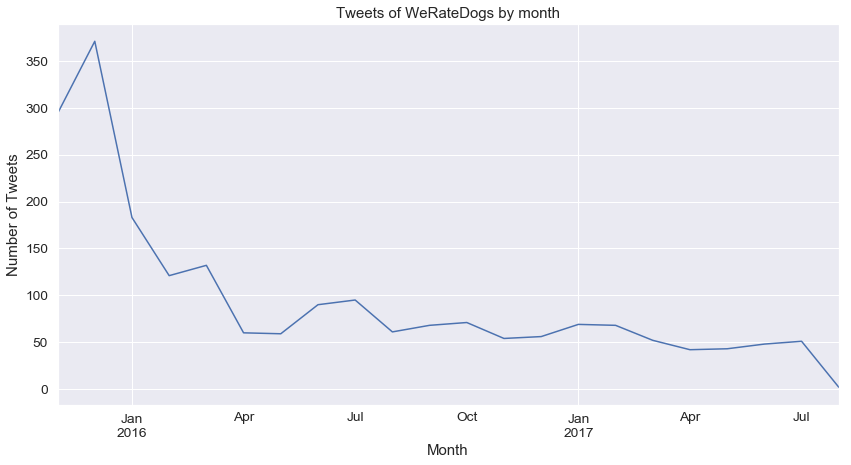

In [106]:
ax = twitter_master.timestamp.groupby(twitter_master.timestamp.dt.to_period('M')).agg('count').plot(figsize=(14,7))
ax.set_title('Tweets of WeRateDogs by month').set_fontsize(15)
ax.set_xlabel('Month')
ax.set_ylabel('Number of Tweets');
plt.savefig('Tweets of WeRateDogs by month.png', bbox_inches='tight')

##### Observation :

We observed that the number of tweets reduced over time. So, how will that co-relate to the popularity for the twitter account. 

Information about favorite_count and retweet_count

In [67]:
# shows descriptive information about favorite counts
twitter_master['favorite_count'].describe()

count      2087.000000
mean       8732.443220
std       12670.037788
min          77.000000
25%        1947.500000
50%        3972.000000
75%       10886.000000
max      163094.000000
Name: favorite_count, dtype: float64

In [68]:
# shows descriptive information about retweet counts
twitter_master['retweet_count'].describe()

count     2087.000000
mean      2694.597508
std       4713.998617
min         11.000000
25%        596.500000
50%       1305.000000
75%       3063.500000
max      82931.000000
Name: retweet_count, dtype: float64

Let's check for the re-tweets and replies over time.
##### Retweets Over time

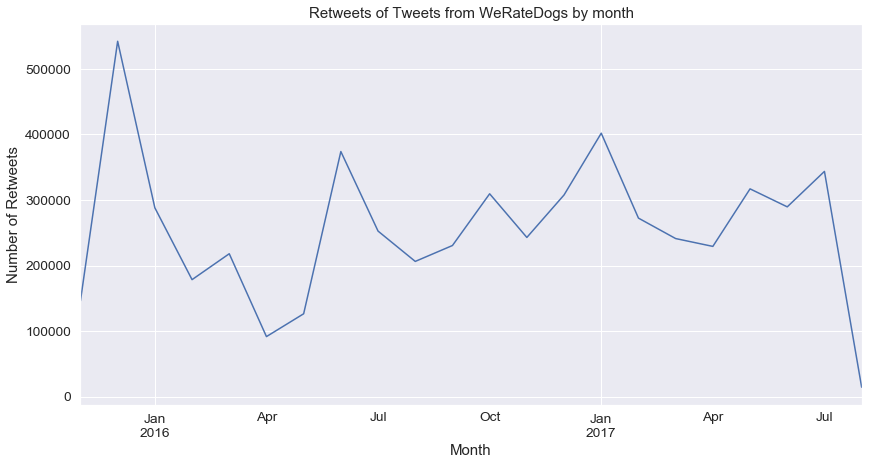

In [107]:
ax2 = twitter_master.retweet_count.groupby(twitter_master.timestamp.dt.to_period('M')).agg('sum').plot(figsize=(14,7))
ax2.set_title('Retweets of Tweets from WeRateDogs by month').set_fontsize(15)
ax2.set_xlabel('Month')
ax2.set_ylabel('Number of Retweets');
plt.savefig('Retweets of Tweets from WeRateDogs by month.png', bbox_inches='tight')

##### Observation:
The total number of retweets have ups and downs with a trent upwards

Let's try to make it clear by plotting the average retweets over time.

##### Average retweets over time

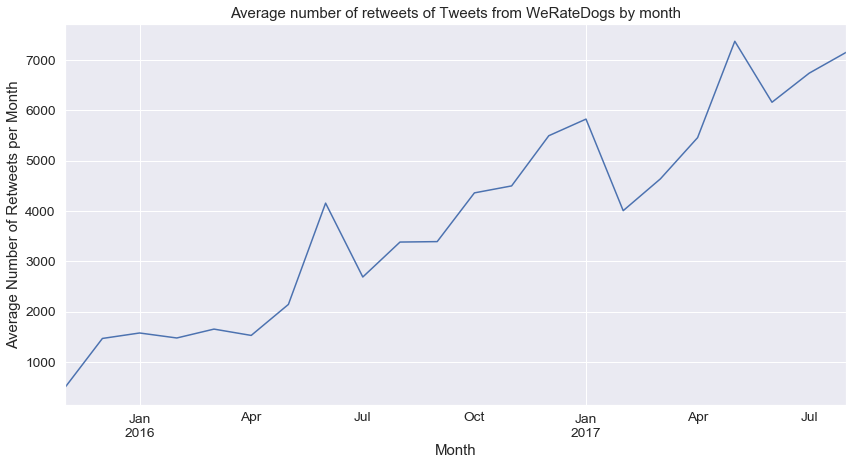

In [108]:
ax3 = twitter_master.retweet_count.groupby(twitter_master.timestamp.dt.to_period('M')).agg('mean').plot(figsize=(14,7))
ax3.set_title('Average number of retweets of Tweets from WeRateDogs by month').set_fontsize(15)
ax3.set_xlabel('Month')
ax3.set_ylabel('Average Number of Retweets per Month');
plt.savefig('Average number of retweets of Tweets from WeRateDogs by month.png', bbox_inches='tight')

The trend is more clear in this plot. The average number of retweets raised over time. 

##### Average Favorites over time

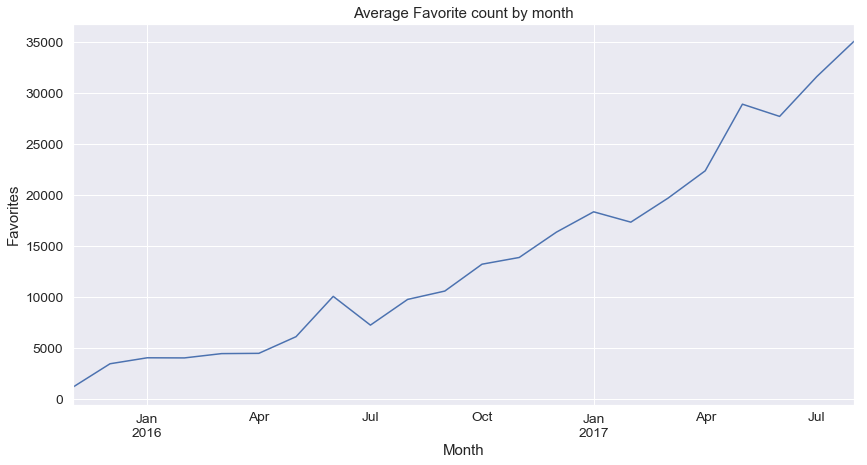

In [109]:
ax4 = twitter_master.favorite_count.groupby(twitter_master.timestamp.dt.to_period('M')).agg('mean').plot(figsize=(14,7))
ax4.set_title('Average Favorite count by month').set_fontsize(15)
ax4.set_xlabel('Month')
ax4.set_ylabel('Favorites');
plt.savefig('Average Favorite count over by month.png', bbox_inches='tight')

As with retweets for favorites the trend upwards is visible. That's an effect that is expected because the more popular a Twitter account the more followers the more retweets and favorites.

##### Ratings over time
How did the ratings change over time?

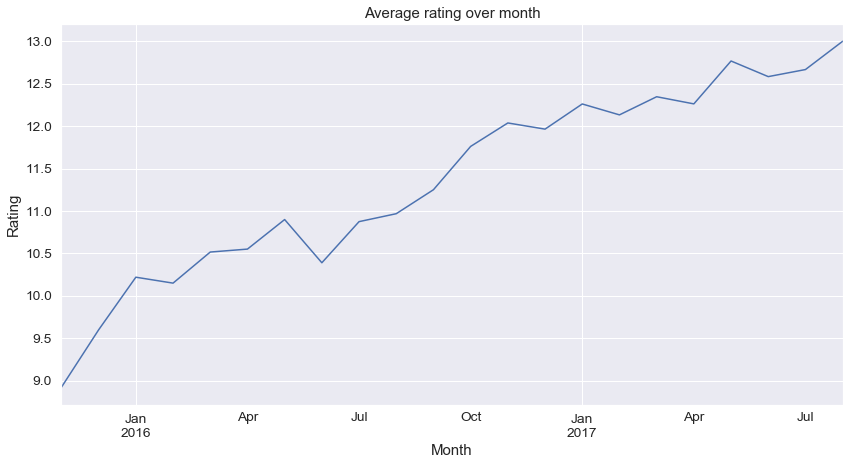

In [110]:
ax5 = twitter_master.rating_numerator.groupby(twitter_master.timestamp.dt.to_period('M')).agg('mean').plot(figsize=(14,7))
ax5.set_title('Average rating over month').set_fontsize(15)
ax5.set_xlabel('Month')
ax5.set_ylabel('Rating');
plt.savefig('Average rating over month.png', bbox_inches='tight')

It is now clear that the ratings did increase over the time. Does that correlate with the number of favorites and retweets?

In [62]:
twitter_master[twitter_master.rating_numerator < 15][['favorite_count', 'retweet_count', 'rating_numerator']].corr()

,favorite_count,retweet_count,rating_numerator
favorite_count,1.000000,0.927231,0.381799
retweet_count,0.927231,1.000000,0.292026
rating_numerator,0.381799,0.292026,1.000000


The rating does not correlate much with the number of retweets and favorite counts. which means that the rating itself does not explain the high numbers of retweets.

In contrast the number of retweets and favorites correlate strong. This is expected because the more retweets the more people can favorite the tweet.

I think that the rating itself is not the gist of these tweets but the Tweet text itself. I think this is due to the sense of humor of @dog_rates and the text he comments every image.

##### Dog breed, stages and Names

In [63]:
# shows the top 10 represented dog breeds in the dataset
twitter_master['breed_pred'].value_counts()[:10]

golden retriever      137
labrador retriever     93
pembroke               88
chihuahua              74
pug                    53
samoyed                40
chow                   39
toy poodle             37
pomeranian             36
malamute               29
Name: breed_pred, dtype: int64

In [64]:
# shows the top 10 represented dog names in the dataset
twitter_master['name'].value_counts()[:10]

Charlie    11
Lucy       11
Cooper     10
Oliver     10
Penny       9
Tucker      9
Sadie       8
Lola        8
Winston     8
Toby        7
Name: name, dtype: int64

<a id='Asking Questions'></a> [Asking Questions](#Asking_Questions)

- Which dog breed recieved the highest ratings on average?
- Which breed is most often rated?
- Which dog stage recieved the highest ratings on average?
- Which dog breed recieved the highest favorite count on average?
- Which dog stage recieved the highest favorite count on average?

##### Which dog breed recieved the highest ratings on average?

We will only include the dogs that have received at least 10 different ratings. Any breed category below 10 entries are likely to be coincidential. The assumption is, that certain type of dogs would recieve higher ratings, than others.

In [70]:
# groups the dataset by dog breeds and computes the average rating for each group
breed_groups = twitter_master.groupby('breed_pred')['rating_numerator'].mean()

# filters out dog breed that appear less than 10 times
breed_groups = breed_groups[twitter_master['breed_pred'].value_counts() > 10].sort_values(ascending=False)
breed_groups

breed_pred
eskimo dog                        11.875000
samoyed                           11.725000
chow                              11.641026
golden retriever                  11.532847
great pyrenees                    11.500000
pembroke                          11.409091
siberian husky                    11.315789
bernese mountain dog              11.272727
cardigan                          11.250000
cocker spaniel                    11.240000
french bulldog                    11.222222
rottweiler                        11.187500
pomeranian                        11.166667
pekinese                          11.166667
labrador retriever                11.118280
toy poodle                        11.054054
german shepherd                   11.000000
kuvasz                            11.000000
malamute                          11.000000
american staffordshire terrier    11.000000
shih tzu                          10.866667
vizsla                            10.833333
miniature pinscher   

Let's plot a Bar chart to visulize our findings.

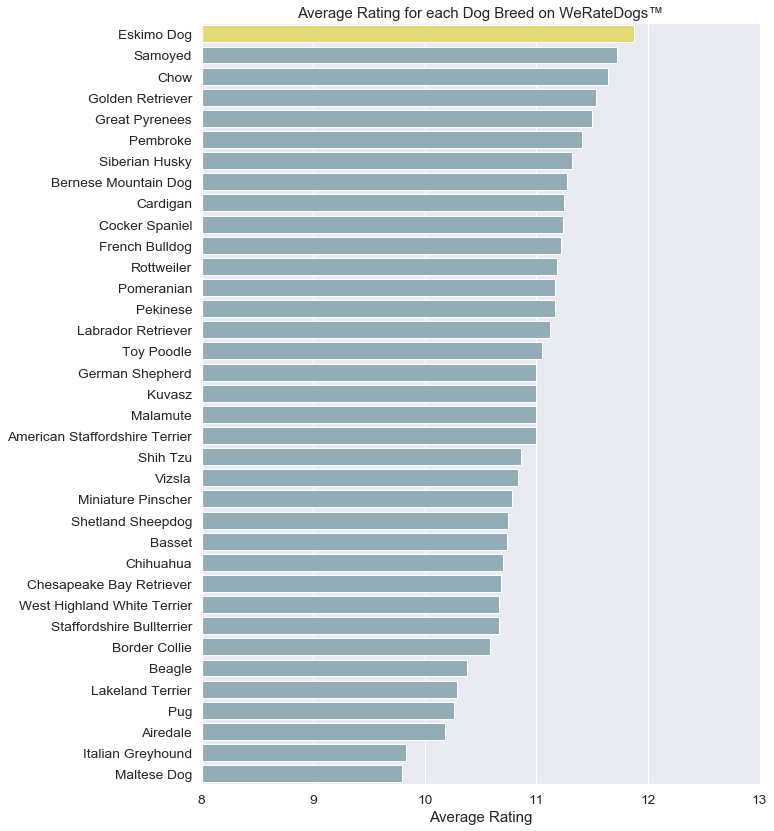

In [71]:
# define axis values
x_axis = list(breed_groups)
y_axis = [i.title() for i in breed_groups.index]

# plot the bar chart
plt.figure(figsize=[10,14])
plt.xlim(8,13)
plt.xlabel('Average Rating')
plt.title('Average Rating for each Dog Breed on WeRateDogs™')
colors = ['#8dafbe' if (x < max(x_axis)) else '#f8e863' for x in x_axis]
ax6 = sns.barplot(x=x_axis, y=y_axis, label=y_axis, color="b", palette=colors)
plt.savefig('rating_each_breed.png', bbox_inches='tight')
plt.show();

##### Observation:

Eskimo dogs recieved the highest ratings on WeRateDogs with an average rating of 11.875, followed by Samoyeds with an average rating of 11.725 and Chows with an average rating of 11.641.

##### Which breed is most often rated?

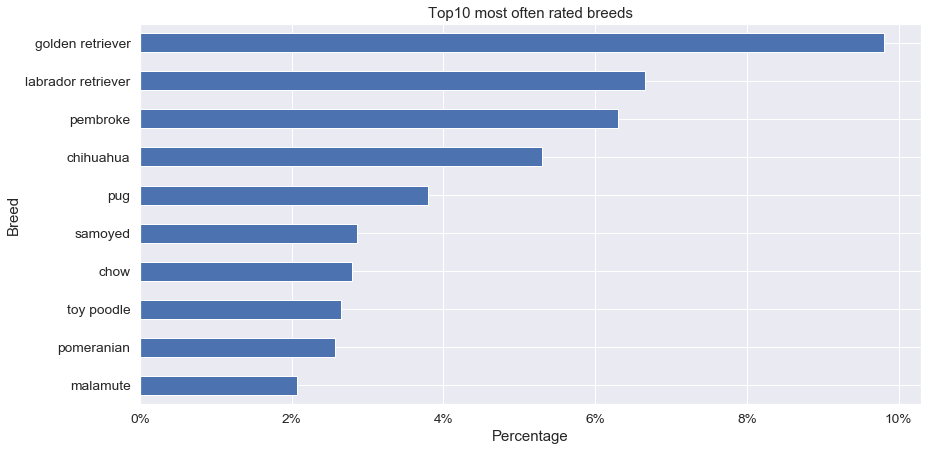

In [104]:
ax6 = twitter_master.breed_pred.value_counts(normalize=True).nlargest(10).plot(kind = 'barh', figsize=(14,7))
ax6.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax6.invert_yaxis()
ax6.set_title('Top10 most often rated breeds').set_fontsize(15)
ax6.set_xlabel('Percentage')
ax6.set_ylabel('Breed');
plt.savefig('Top10 most often rated breeds.png', bbox_inches='tight')

##### Which dog stage recieved the highest ratings on average?

In [72]:
#Check the different dog stages
twitter_master['stage'].value_counts()

pupper     244
doggo       91
puppo       28
floof       27
floofer      9
Name: stage, dtype: int64

In [73]:
# puts floof and floofers into the same category 'floof'
twitter_master['stage'] = twitter_master['stage'].replace('floofer', 'floof')

In [76]:
# groups the dataset by dog stages and computes the average rating for each group
stage_groups = twitter_master.groupby('stage')['rating_numerator'].mean()

# sorts the stage groups by descending order
stage_groups = stage_groups.sort_values(ascending=False)
stage_groups

stage
puppo      12.107143
doggo      11.725275
floof      11.694444
pupper     10.688525
floofer          NaN
Name: rating_numerator, dtype: float64

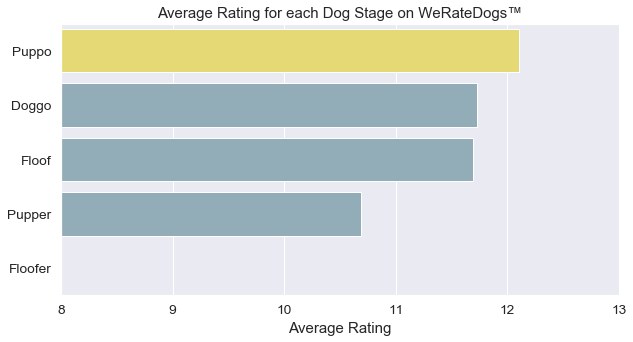

In [79]:
# define axis values
x_axis = list(stage_groups)
y_axis = [i.title() for i in stage_groups.index]

# plot the bar chart
plt.figure(figsize=[10,5])
plt.xlim(8,13)
plt.xlabel('Average Rating')
plt.title('Average Rating for each Dog Stage on WeRateDogs™')
colors = ['#8dafbe' if (x < max(x_axis)) else '#f8e863' for x in x_axis]
ax = sns.barplot(x=x_axis, y=y_axis, label=y_axis, color="b", palette=colors)
plt.savefig('rating_each_stage.png', bbox_inches='tight')
plt.show();

##### Observation: 

Puppo's recieved the highest ratings on WeRateDogs with an average rating of 12.107, while pupper's, which basically are puppies, recieved the lowest ratings with an average rating of 10.689.

##### Which dog breed recieved the highest favorite counts on average?

In [80]:
# groups the dataset by dog breeds and computes the average favorite count for each group
breed_groups_fav = twitter_master.groupby('breed_pred')['favorite_count'].mean()

# filters out dog breed that appear less than 10 times
breed_groups_fav = breed_groups_fav[twitter_master['breed_pred'].value_counts() > 10].sort_values(ascending=False)
breed_groups_fav

breed_pred
french bulldog                    17714.115385
eskimo dog                        15694.500000
cardigan                          14108.750000
samoyed                           13713.487179
great pyrenees                    12269.142857
golden retriever                  11810.795620
basset                            11685.800000
cocker spaniel                    11641.720000
labrador retriever                11595.847826
malamute                          11560.620690
pembroke                          11062.670455
chesapeake bay retriever          10486.681818
italian greyhound                 10082.583333
staffordshire bullterrier          9755.111111
german shepherd                    9665.250000
chow                               9663.000000
chihuahua                          8950.878378
border collie                      8534.750000
shetland sheepdog                  8196.125000
miniature pinscher                 8088.666667
rottweiler                         7664.687500
pe

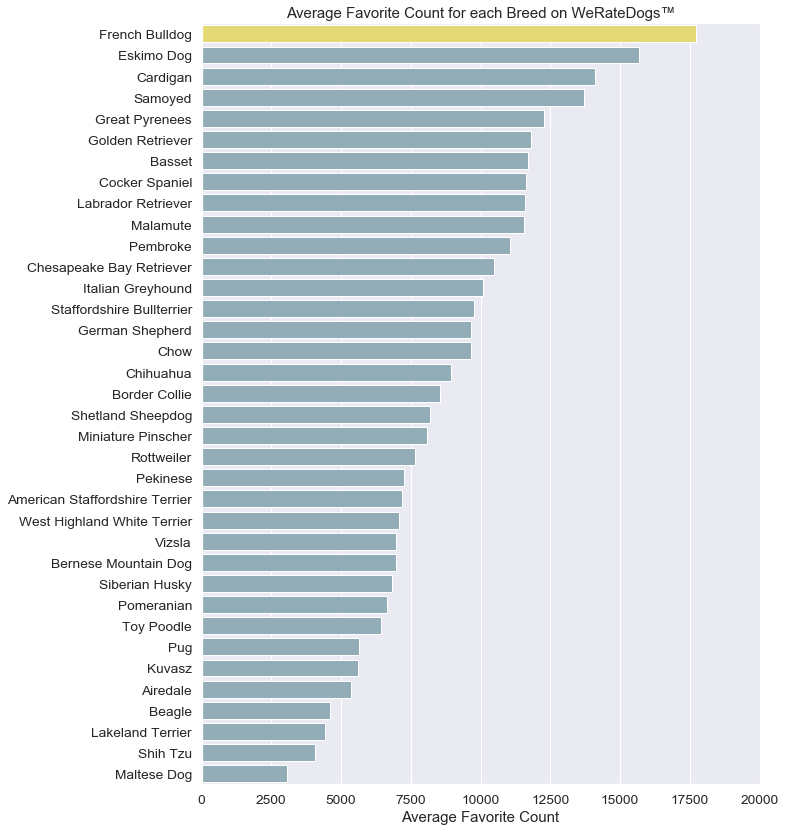

In [114]:
# define axis values
x_axis = list(breed_groups_fav)
y_axis = [i.title() for i in breed_groups_fav.index]

# plot the bar chart
plt.figure(figsize=[10,14])
plt.xlim(0, 20000)
plt.xlabel('Average Favorite Count')
plt.title('Average Favorite Count for each Breed on WeRateDogs™')
colors = ['#8dafbe' if (x < max(x_axis)) else '#f8e863' for x in x_axis]
ax = sns.barplot(x=x_axis, y=y_axis, label=y_axis, color="b", palette=colors)
plt.savefig('Average Favorite Count for each Breed.png', bbox_inches='tight')
plt.show();


##### Observation: 

French Bulldogs have scored the highest between all dog breeds with an average favorite count of 17949 per tweet, contrary to the average ratings, in which they only placed 11th. The second most popular dog breed on WeRateDogs is the Eskimo Dog with an average favorite counnt of 15911 per tweet, which also placed 1st on the average rating chart.

##### Which dog stage recieved the highest favorite count on average?

In [83]:
# groups the dataset by dog stages and computes the average favorite count for each group
stage_groups_fav = twitter_master.groupby('stage')['favorite_count'].mean()

# sorts the stage groups by descending order
stage_groups_fav = stage_groups_fav.sort_values(ascending=False)
stage_groups_fav

stage
puppo      21786.678571
doggo      17407.692308
floof       8401.444444
pupper      6855.729508
floofer             NaN
Name: favorite_count, dtype: float64

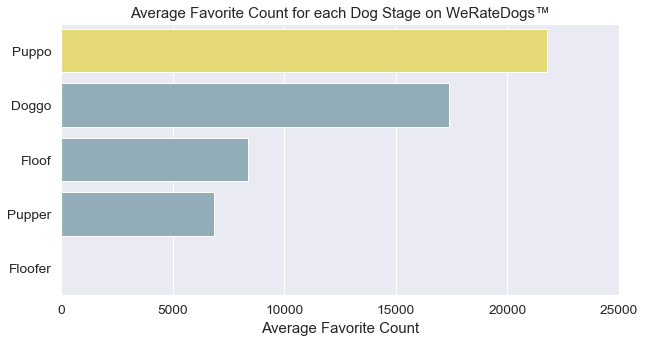

In [115]:
# define axis values
x_axis = list(stage_groups_fav)
y_axis = [i.title() for i in stage_groups_fav.index]

# plot the bar chart
plt.figure(figsize=[10,5])
plt.xlim(0,25000)
plt.xlabel('Average Favorite Count')
plt.title('Average Favorite Count for each Dog Stage on WeRateDogs™')
colors = ['#8dafbe' if (x < max(x_axis)) else '#f8e863' for x in x_axis]
ax = sns.barplot(x=x_axis, y=y_axis, label=y_axis, color="b", palette=colors)
plt.savefig('Average Favorite Count for each Dog Stage on WeRateDogs™.png', bbox_inches='tight')
plt.show();

##### Observation: 

Puppos have recieved the most favorite counts (or "likes") on average between the other dog stages, with an average favorite count of 21786 per tweet. This makes puppos not only the highest rated dog stage, but also the most popular within the WeRateDogs community in the observed time period.

<a id='Visualizations'></a> [Visualizations](#Visualizations)

#### Most used names

What are the most used names for dogs in this dataset?

In [93]:
names = twitter_master.name.str.cat(sep=' ')
stopwords = set(STOPWORDS)
dog_mask = np.array(Image.open('golden_retriever.jpg'))

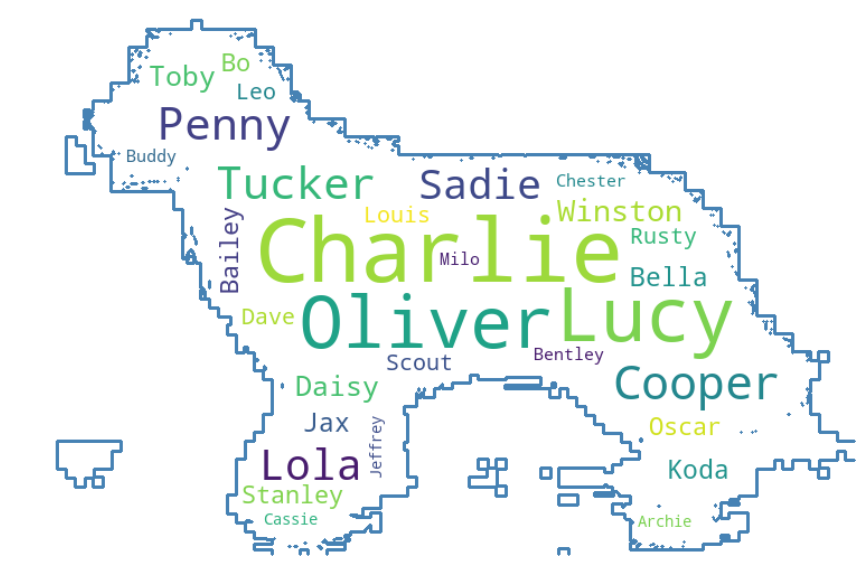

In [116]:
wc = WordCloud(background_color='white', margin=10, max_words=30, mask=dog_mask, 
               stopwords=stopwords, contour_width=3, contour_color='steelblue').generate(names)
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('Most used names on WeRateDogs™.png', bbox_inches='tight')
plt.show()

#### Most used text words

What are the most used words in @dog_rates Tweets?

In [101]:
fulltext = twitter_master.text.str.cat(sep=' ')
stopwords.update(['Meet', 'hello', 'Say'])
tweet_mask = np.array(Image.open('twitter.png'))

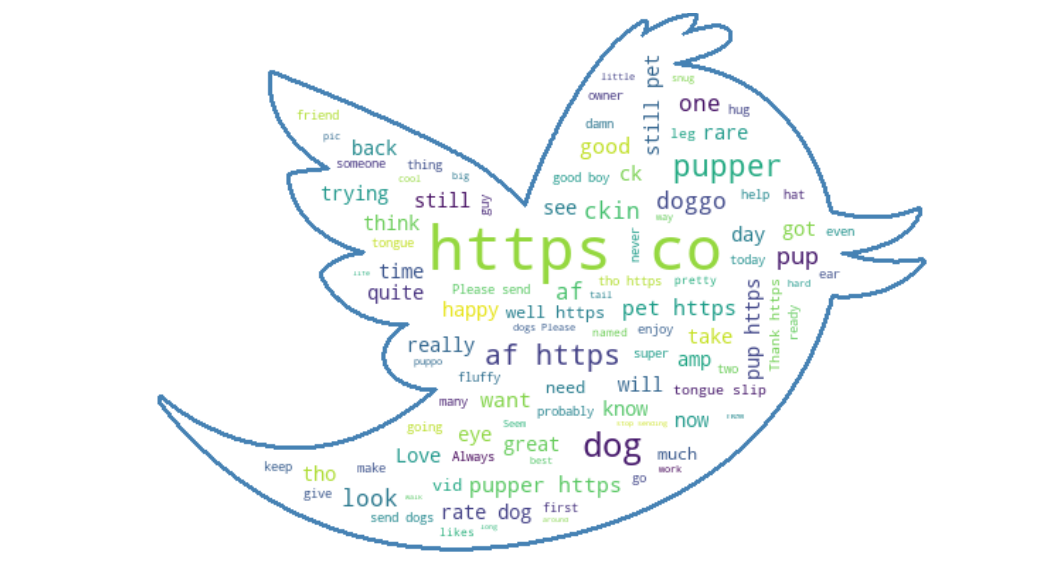

In [117]:
wc = WordCloud(background_color='white', margin=10, max_words=100, stopwords=stopwords, mask=tweet_mask,
               contour_width=3, contour_color='steelblue').generate(fulltext)
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('Most used text words on WeRateDogs™.png', bbox_inches='tight')
plt.show()